In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from cm import plot_confusion_matrix

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

# Build and Evaluate a Logistic Regression Model

A logistic regression is a type of model which can be used when predicting a categorial outcome. Specifically, it outputs a predicted probability that an observation is in one class or the other.

In this notebook, you'll see how to build a logistic regression model to predict whether a passenger on the Titanic would have lived or died.

In [2]:
titanic = pd.read_csv('../data/titanic.csv')

In [3]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [4]:
titanic.Survived.value_counts()

0    545
1    342
Name: Survived, dtype: int64

We can see that 342 passengers survived and 545 died.

In [5]:
titanic.Survived.value_counts(normalize = True)

0    0.614431
1    0.385569
Name: Survived, dtype: float64

61% of passengers died.

Now, let's see how survival relates to some of our variables.

Starting with the passenger class, we can use the `pandas` `crosstab` method to get a count or proportion of survival by passenger class.

In [6]:
pd.crosstab(titanic['Pclass'], titanic['Survived'])

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,368,119


In [7]:
pd.crosstab(titanic['Pclass'], titanic['Survived'], normalize='index')

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.755647,0.244353


We can turn this table into a bar plot.

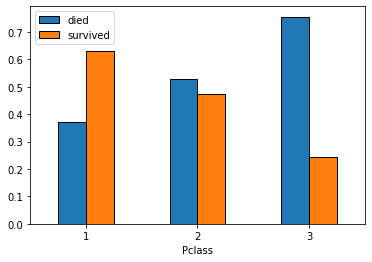

In [8]:
pd.crosstab(titanic['Pclass'], titanic['Survived'], normalize='index').plot(kind = 'bar', edgecolor = 'black')
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left', labels = ['died', 'survived']);

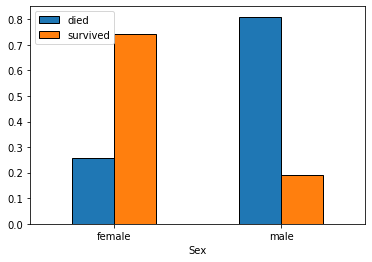

In [9]:
pd.crosstab(titanic['Sex'], titanic['Survived'], normalize='index').plot(kind = 'bar', edgecolor = 'black')
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left', labels = ['died', 'survived']);

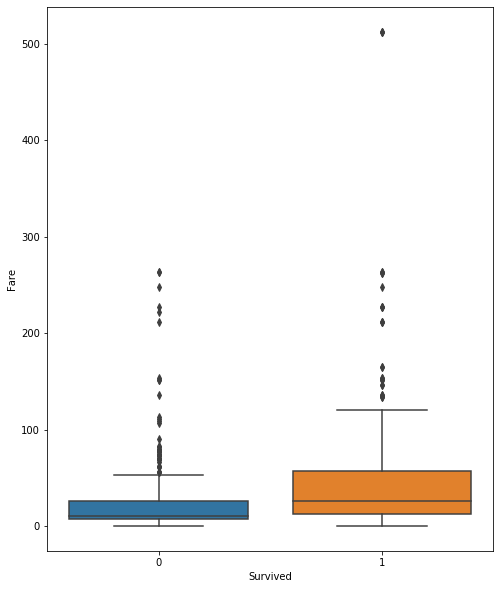

In [10]:

plt.figure(figsize=(8,10))

sns.boxplot(x = 'Survived', y = 'Fare', data = titanic);

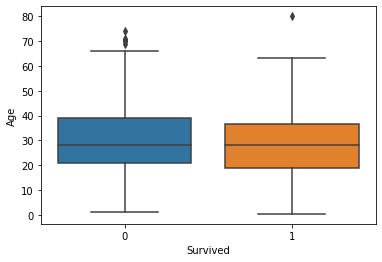

In [11]:
sns.boxplot(x = 'Survived', y = 'Age', data = titanic);

Currently, sex is encoded as a string. You need to encode it numerically before building your model. Also, passenger class is encoded using a number, but it is more like a categorical variable, so should be converted to a _dummy variable_.

In [12]:
titanic = titanic.drop(columns = 'Name') # dont need this column
titanic = pd.get_dummies(titanic, columns = ['Sex', 'Pclass'], drop_first = True)

In [13]:
titanic.head()

,Survived,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_male,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,1,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,0
4,0,35.0,0,0,8.0500,1,0,1


In [14]:
# Predictors
X = titanic.drop(columns = 'Survived')
# Target
y = titanic.Survived

When doing data science, the goal of building models is almost alway to make predictions. The main objective is to have a model which makes good predictions on _unseen_ data. Therefore, in order to evaluate how good a model is, it is necessary to set aside some data as a test set for evaulation purposes. This can be accomplished using the `train_test_split` function.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

In [16]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

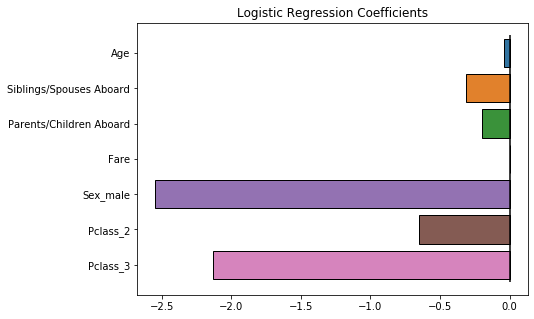

In [17]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients')

ymin, ymax = plt.ylim()
plt.vlines(x = 0, ymin = ymin, ymax = ymax);

For this model, a positive coefficient for a variable means that a higher value for that variable (holding all others constant) corresponds to a higher probability of surviving and a negative coefficient indicates the opposite. So, for example, a male passenger has a lower probability of surviving, all else being equal.

## Analyzing Predicted Probabilities

Recall that a logistic regression model outputs predicted probabilities. You can generate these predicted probabilities using the `predict_proba` method of your model. This outputs the predicted probability of both classes (died and survived), but you only really need the probability of surviving, which you can access by slicing the output.

In [18]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]

In [36]:
i = 3 # can change this number to look at random individuals in the dataset

print('Passenger Information:\n{}'.format(X_test.iloc[i]))
print('---------------------------------')
print('Predicted Probability of Survival: {}'.format(y_pred_prob[i]))

Passenger Information:
Age                        17.0
Siblings/Spouses Aboard     1.0
Parents/Children Aboard     0.0
Fare                       57.0
Sex_male                    0.0
Pclass_2                    0.0
Pclass_3                    0.0
Name: 777, dtype: float64
---------------------------------
Predicted Probability of Survival: 0.9440397842580125


One way to analyze your model is to look at the receiver operating characteristic (ROC) curve. This shows how the true positive rate and false positive rate change as the prediction threshold changes.

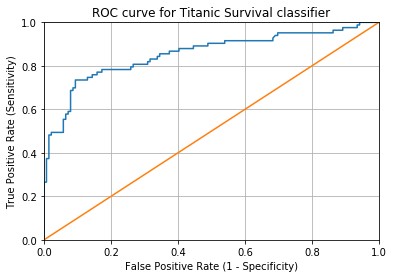

In [24]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Titanic Survival classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.plot([0,1], [0,1]); # gives the s-curve (orange line)

### AUC - percentage of the ROC plot that is under the curve

This corresponds to the probability that the model assigns a higher probability of surviving to a random survivor than to a random passenger who died.

A perfect model would have AUC = 1.

In [25]:
print(metrics.roc_auc_score(y_test, y_pred_prob)) # more data can improve model and AUC

0.8542515385282136


## Analyzing Predictions

To generate predictions, you can use the `predict` method of your model.

In [26]:
y_pred = logistic_model.predict(X_test)

The predictions can be summarized using a confusion matrix.

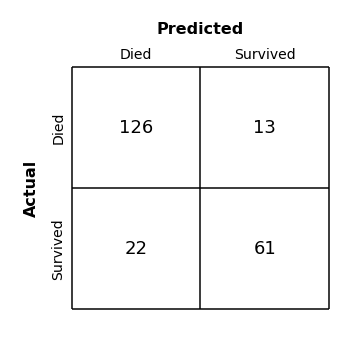

In [27]:
plot_confusion_matrix(y_test, y_pred, labels = ['Died', 'Survived'])

There are a number of metrics you can use to evalute your model. First is accuracy, which is the proportion of predictions which are correct.

In [28]:
print(metrics.accuracy_score(y_test, y_pred))

0.8423423423423423


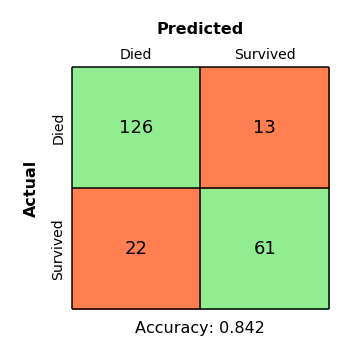

In [29]:
plot_confusion_matrix(y_test, y_pred, labels = ['Died', 'Survived'], metric = 'accuracy')

The naive model which predicts that all passengers died, would only be correct 62% of the time, so our model is significantly better than the naive one.

**Sensitivity/True Positive Rate:** The proportion of true positives (in our case, people who survived) that are identified as such.

In [30]:
print('sensitivity:')
print(metrics.recall_score(y_test, y_pred))

sensitivity:
0.7349397590361446


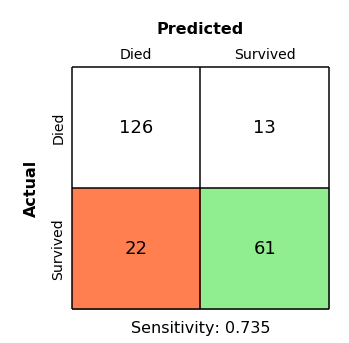

In [31]:
plot_confusion_matrix(y_test, y_pred, labels = ['Died', 'Survived'], metric = 'sensitivity')

**Specificity/True Negative Rate:** The proportion of true negatives (in our case, people who died) that are identified as such.

In [32]:
print('specificity:')
print(125 / (125 + 14))

specificity:
0.8992805755395683


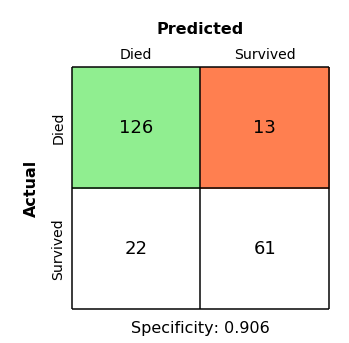

In [33]:
plot_confusion_matrix(y_test, y_pred, labels = ['Died', 'Survived'], metric = 'specificity')

**Precision:** The proportion of predicted positives that are actually positive (survived).

In [34]:
print('precision:')
print(metrics.precision_score(y_test, y_pred))

precision:
0.8243243243243243


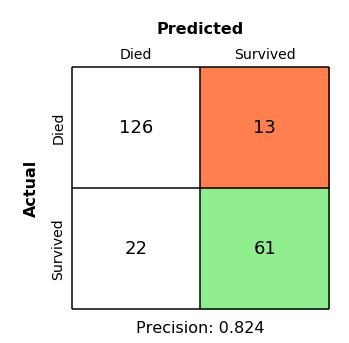

In [35]:
plot_confusion_matrix(y_test, y_pred, labels = ['Died', 'Survived'], metric = 'precision')